# Test Model

Перед запуском этого файла локально убедись:
- в правильном порядке директорий (Используются,server,worker,data,Model,StatisticClass)\

   |-Models\
   |---CNN_model\
   |-----models\
   |-------Data.py\
   |-------Model.py\
   |---FederatedLearning\
   |-------Server.py\
   |-------Worker.py\
   |---MatrixScheduler\
   |---Optimisers\
   |---Preconditioners\
   |-StatisticClass.py\

- установленны Tensorboard, torch, torchvision
Tensorboard:

```
!pip install tensorboard
```


In [1]:
import os

os.chdir("./Models/CNN_model")
#!ls
from Model import Model
from Data import Data

os.chdir("../..")
!ls

from Models.FederatedLearning.Server import server
from Models.StatisticClass import Statistic,array_mean_object
from Models.Optimizers.Adam import Adam
from Models.Optimizers.OASIS import OASIS

#os.chdir("../Reports")
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import seaborn as sns

import torch
#!ls

data	Pictures   Report_Local.ipynb  runs	  Test.ipynb
Models	README.md  Reports	       Runs_stat  ПередПрименением.txt


## Data  

In [2]:
def draw_distribution(name,d):
    print(name)
    trains,tests = d.get_data()

    for i,(train,test) in enumerate(zip(trains,tests)):
        plt.figure(figsize=(10, 5))

        val,counts = np.unique(train.targets,return_counts = True)
        val1,counts1 = np.unique(test.targets,return_counts = True)

        plt.subplot(121)
        plt.bar(val,counts)
        plt.subplot(122)
        plt.bar(val1,counts1)
        plt.suptitle(f"worker {i}")
        plt.show()
        print(len(train),len(test),"% of test ",len(test)/(len(train)+len(test)))

In [3]:
def heatmap_plot(indexes):
    
    indexes = indexes.copy()
    dim = int(np.sqrt(indexes.shape[0]))+1

    indexes.resize(dim,dim)
    plt.imshow(indexes, cmap='hot', interpolation='nearest')
    plt.show()
    #sns.heatmap(indexes, vmin=0, vmax=50_000)

def check_randomness(d):
    train,test = d.get_data()
    for i,(data_t,data_test) in enumerate(zip( train,test )):
        print(f"Part {i}")
        print("Train")
        idexes = np.array(data_t.indices)
        heatmap_plot(idexes)
        
        print("Test")
        idexes = np.array(data_test.indices)
        heatmap_plot(idexes)

In [4]:
Data.SPLITS

['het',
 'ident',
 'random_indent',
 'ident_same',
 'noSplit',
 'noSplit_test_split']

In [ ]:
n,d = Data.SPLITS[0], Data(split = Data.SPLITS[0],n_workers=3,environment = "")
n1,d1 = Data.SPLITS[1], Data(split = Data.SPLITS[1],n_workers=3,environment = "")
n2,d2 = Data.SPLITS[2], Data(split = Data.SPLITS[2],n_workers=3,environment = "")
n3,d3 = Data.SPLITS[3], Data(split = Data.SPLITS[3],n_workers=3,environment = "")
n4,d4 = "noSplit", Data(split = "noSplit",n_workers=1,environment = "")
n5,d5 = Data.SPLITS[-1], Data(split = Data.SPLITS[-1],n_workers=3,environment = "")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
idx = np.arange(50_000)
idx

In [ ]:
heatmap_plot(idx)

In [ ]:
check_randomness(d)

In [ ]:
draw_distribution(name=n,d=d)

In [ ]:
check_randomness(d1)

In [ ]:
draw_distribution(name=n1,d=d1)

In [ ]:
check_randomness(d2)

In [ ]:
draw_distribution(name=n2,d=d2)

In [ ]:
check_randomness(d3)

In [ ]:
draw_distribution(name=n3,d=d3)

In [ ]:
d4

In [ ]:
draw_distribution(name=n4,d=d4)

In [ ]:
check_randomness(d5)

In [ ]:
draw_distribution(name=n5,d=d5)

## Models first try

### Model run

In [2]:
d = Data(split = "noSplit",n_workers=1,environment = "")

Files already downloaded and verified
Files already downloaded and verified


In [3]:
m = Model("Test_Model")
m.set_optimizer(optim.SGD(m.net.parameters(), lr=0.01))

trainloader = d.get_data_loaders()[0]['trainloader']
testloader = d.get_data_loaders()[0]['testloader']

m.run(epoch = 5,train_loader = trainloader,test_loader = testloader)

In [4]:
m.optimizer.param_groups[0].keys()

dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov', 'maximize', 'foreach', 'differentiable'])

In [5]:
m.stat_collector.weights

[array(-0.0553619, dtype=float32),
 array(-0.0553619, dtype=float32),
 array(-0.0553619, dtype=float32),
 array(-0.0553619, dtype=float32),
 array(-0.0553619, dtype=float32)]

### Federated learning

In [2]:
def model_creator(w_num):
    name = f"Test_FederatedModelSingleW_ident_{w_num}_"
    
    model = Model(name)
    model.set_optimizer(optim.SGD(model.net.parameters(), lr=0.01))
    return model

In [3]:
def model_creator1(w_num):
    name = f"Federated_ident_{w_num}_"
    
    model = Model(name)
    model.set_optimizer(optim.SGD(model.net.parameters(), lr=0.01))
    return model

In [4]:
d1 = Data(split = "ident",n_workers=3,environment = "")

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
s = server(num_workers=1,data = d.get_data_loaders(),model_creator=model_creator)
s.run(n_iter=5,T=1)

In [8]:
s = server(num_workers=3,data = d1.get_data_loaders(),model_creator=model_creator1,same_init = False)
s.run(n_iter=20,T=4)

stat_collectors = [w.model.stat_collector for w in s.workers]
stat_collector = array_mean_object(stat_collectors,"Federated_ident")

 20%|████████▊                                   | 4/20 [01:10<04:41, 17.57s/it]

size: 10


 40%|█████████████████▌                          | 8/20 [02:24<03:38, 18.17s/it]

size: 10


 60%|█████████████████████████▊                 | 12/20 [03:38<02:26, 18.31s/it]

size: 10


 80%|██████████████████████████████████▍        | 16/20 [04:56<01:14, 18.74s/it]

size: 10


100%|███████████████████████████████████████████| 20/20 [06:10<00:00, 18.54s/it]

size: 10


In [7]:
iterations = np.arange(0,20,4)[1:]
print(iterations)
a = np.arange(20)
a, np.array(a) [iterations]

[ 4  8 12 16]


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([ 4,  8, 12, 16]))

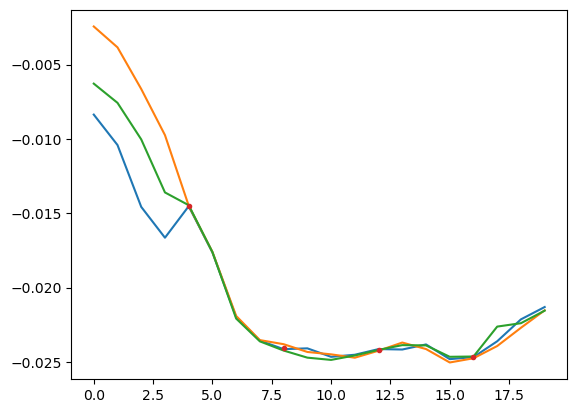

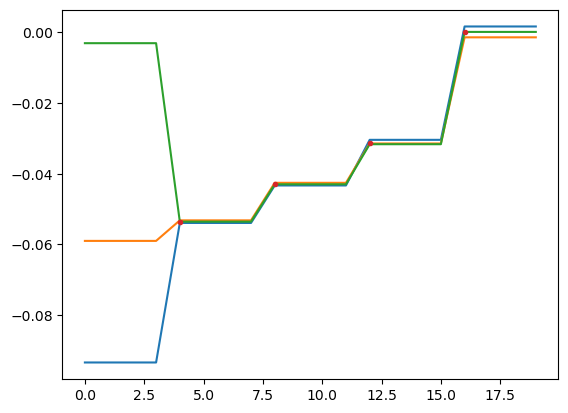

In [9]:
iterations = np.arange(0,20,4)[1:]
val = np.zeros(len(iterations))

for sc in stat_collectors:
    val+= np.array( sc.weights_mean )[iterations]
    
    plt.plot(np.arange(sc.iterations),sc.weights_mean)
plt.plot(iterations,val/3,'.')
plt.show()


val = np.zeros(len(iterations))
for sc in stat_collectors:
    val+= np.array( sc.weights )[iterations]
    
    plt.plot(np.arange(sc.iterations),sc.weights)
plt.plot(iterations,val/3,'.')
plt.show()

In [4]:
d1 = Data(split = "het",n_workers=3,environment = "")

s = server(num_workers=3,data = d1.get_data_loaders(),model_creator=model_creator1,same_init = False)
s.run(n_iter=20,T=4)

stat_collectors = [w.model.stat_collector for w in s.workers]
stat_collector = array_mean_object(stat_collectors,"Federated_het")

Files already downloaded and verified
Files already downloaded and verified


 20%|████████▊                                   | 4/20 [01:08<04:35, 17.23s/it]

size: 10


 40%|█████████████████▌                          | 8/20 [02:25<03:41, 18.42s/it]

size: 10


 40%|█████████████████▌                          | 8/20 [03:41<05:32, 27.68s/it]


KeyboardInterrupt: 

## Optimizers

### Adam

In [4]:
p = torch.tensor([1])
m = Model("Test_Model")

adam_opt = Adam(params = m.net.parameters(),beta2 = 0.4,lr=0.002)

In [5]:
# grad_val = torch.tensor([0.1,0.02,0.05,2])
# adam_opt.current_iter = 3
# try:
#     adam_opt.count_sum(grad_list = [grad_val,grad_val,grad_val])
#     print("Succed")
# except AssertionError as e:
#     print("Failed",e)

TypeError: Adam.count_sum() got an unexpected keyword argument 'grad_list'

In [6]:
def step(grad_vals):
    #grad_val = torch.tensor([0.1,0.02,0.05,2])
    res = adam_opt.count_sum(prev_iter_sum = 0,
                             current_grad = grad_vals)
    res1_inv,res1 = adam_opt.count_param_d(D_k_sum = res)
    
    return res,res1,res1_inv

In [7]:
adam_opt.current_iter = 1
step(grad_vals = torch.tensor([0.1,0.02,0.05,2]))

(tensor([1.0000e-02, 4.0000e-04, 2.5000e-03, 4.0000e+00]),
 tensor([1.0000e-02, 4.0000e-04, 2.5000e-03, 4.0000e+00]),
 tensor([10.0000, 50.0000, 20.0000,  0.5000]))

In [16]:
adam_opt.current_iter = 3
step(grad_vals = [torch.tensor([0.1,  0.02, 1, 10]),
                  torch.tensor([0.01, 0.01, 1, 1]),
                  torch.tensor([0.001,0,    1, 0.1])])

(tensor([1.6410e-03, 1.0400e-04, 1.5600e+00, 1.6410e+01]),
 tensor([1.0519e-03, 6.6667e-05, 1.0000e+00, 1.0519e+01]),
 tensor([ 30.8324, 122.4745,   1.0000,   0.3083]))

In [2]:
import torch
a = torch.tensor([1,2,3,4])
a,a.shape

(tensor([1, 2, 3, 4]), torch.Size([4]))

### Second Derivative

In [3]:
for i in torch.tensor([[1,.1,12,9],[1,.1,12,9]]):
    print(i)

tensor([ 1.0000,  0.1000, 12.0000,  9.0000])
tensor([ 1.0000,  0.1000, 12.0000,  9.0000])


In [5]:
m = Model("Test_Model")
m.set_optimizer(optim.SGD(m.net.parameters(), lr=0.01))

d = Data(split = "noSplit",n_workers=1,environment = "")
trainloader = d.get_data_loaders()[0]['trainloader']
testloader = d.get_data_loaders()[0]['testloader']

m.run(epoch = 2,train_loader = trainloader,test_loader = testloader)

next(m.net.parameters()).shape,next(m.net.parameters()).grad.data.shape

Files already downloaded and verified
Files already downloaded and verified


(torch.Size([6, 3, 5, 5]), torch.Size([6, 3, 5, 5]))

In [24]:
next(m.net.parameters()).shape,next(m.net.parameters()).grad.data.shape, torch.autograd.grad(next(m.net.parameters()).grad.data, next(m.net.parameters()).data)[0]

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [10]:
p1 = next(m.net.parameters())
p11 = torch.autograd.grad(p11,p1)
 create_graph=True
p11 = next(m.net.parameters()).grad.data.reshape(-1)[0]#.grad.data

In [11]:
torch.autograd.grad(p11,p1)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [14]:
assert 1!=1,1!=1

AssertionError: False

In [18]:
x = torch.tensor([[.1,2,3],[1,.8,.2]],requires_grad=True)
y = torch.tensor([[.1,2,3],[1,.8,.2]],requires_grad=True)
loss_fn = torch.nn.MSELoss()
def loss(x,y):
    return loss_fn(x,y)

h = torch.autograd.functional.hessian(loss,(x,y))

print(len(h))
h[0][0]

2


tensor([[[[-0.3333, -0.0000, -0.0000],
          [-0.0000, -0.0000, -0.0000]],

         [[-0.0000, -0.3333, -0.0000],
          [-0.0000, -0.0000, -0.0000]],

         [[-0.0000, -0.0000, -0.3333],
          [-0.0000, -0.0000, -0.0000]]],


        [[[-0.0000, -0.0000, -0.0000],
          [-0.3333, -0.0000, -0.0000]],

         [[-0.0000, -0.0000, -0.0000],
          [-0.0000, -0.3333, -0.0000]],

         [[-0.0000, -0.0000, -0.0000],
          [-0.0000, -0.0000, -0.3333]]]])

In [ ]:
# x = torch.tensor([.1,1],requires_grad=True)
# y = torch.tensor([.5,10],requires_grad=True)
# loss_fn = torch.nn.MSELoss()
# f = ((x-y)**2).sum()

# #f.forward()

# dfdx = torch.autograd.grad(f,x,create_graph=True)[0]
# print(dfdx)
# ddx = torch.autograd.grad(dfdx[0],x)
# ddx

In [6]:
x = torch.tensor([.1,1],requires_grad=True)
#y = torch.tensor([.5,10],requires_grad=True)
#loss_fn = torch.nn.MSELoss()
#f = ((x-y)**2).sum()
f = ((x[0]-x[1])**2)

#f.forward()

dfdx = torch.autograd.grad(f,x,create_graph=True)[0]
print(dfdx)

derivative_array = []
for d in dfdx:
    print(d)
    ddx = torch.autograd.grad(d,x,retain_graph=True)[0]
    derivative_array.append(ddx)

derivative_array = torch.stack(derivative_array)
derivative_array

tensor([-1.8000,  1.8000], grad_fn=<AddBackward0>)
tensor(-1.8000, grad_fn=<UnbindBackward0>)
tensor(1.8000, grad_fn=<UnbindBackward0>)


tensor([[ 2., -2.],
        [-2.,  2.]])

In [13]:
x = torch.tensor([[.1],[1]],requires_grad=True)
y = torch.tensor([[.5],[10]],requires_grad=True)
loss_fn = torch.nn.MSELoss(reduction='sum')
f = loss_fn(x,y)
#f1 = f.clone()
f.backward(create_graph=True)

dfdx = x.grad.reshape(-1)
print(dfdx)

derivative_array = []
for d in dfdx:
    ddx = torch.autograd.grad(d,x,retain_graph=True)[0].reshape(-1)
    print(ddx)
    derivative_array.append(ddx)

derivative_array = torch.stack(derivative_array)
derivative_array

tensor([ -0.8000, -18.0000], grad_fn=<ReshapeAliasBackward0>)
tensor([2., 0.])
tensor([0., 2.])


tensor([[2., 0.],
        [0., 2.]])

In [34]:
from torch.autograd.functional import hessian

x = torch.tensor([.1,1],requires_grad=True)
y = torch.tensor([.5,10],requires_grad=True)
loss_fn = torch.nn.MSELoss(reduction='sum')
f = loss_fn(x,y)
#f1 = f.clone()
f.backward(create_graph=True)


TypeError: 'Tensor' object is not callable

In [26]:
dfdx

<function Tensor.clone>

In [10]:
dfdx = torch.autograd.grad(f,x,create_graph=True)[0]

In [ ]:
dfdx

In [5]:
x = torch.tensor([.1,.2,.3,.4,5.],requires_grad=True)
y = torch.tensor([1.,.1,.3,3.,.5],requires_grad=True)
loss_fn = torch.nn.MSELoss()
f = ((x-y)**2).sum()

#f.forward()

dfdx = torch.autograd.grad(f,x,create_graph=True)[0]
print(dfdx)
ddx = torch.autograd.grad(dfdx[0],x)
ddx

tensor([-1.8000,  0.2000,  0.0000, -5.2000,  9.0000], grad_fn=<MulBackward0>)


(tensor([2., 0., 0., 0., 0.]),)

In [18]:
x = torch.tensor([[.1,.2],[.3,.4]],requires_grad=True)
y = torch.tensor([1.,.1,.3,3.,.5],requires_grad=True)
loss_fn = torch.nn.MSELoss()
#f = ((x-y)**2).sum()


# #f.forward()

# dfdx = torch.autograd.grad(f,x,create_graph=True)[0]
# print(dfdx)
# ddx = torch.autograd.grad(dfdx[0],x)
# ddx

torch.flip(x,[0])

tensor([[0.3000, 0.4000],
        [0.1000, 0.2000]], grad_fn=<FlipBackward0>)

In [41]:
2*(x-y)

tensor([-1.8000,  0.2000,  0.0000, -5.2000,  9.0000], grad_fn=<MulBackward0>)

In [19]:
x = torch.tensor([1,2,3,4])
torch.numel(x)
#y = x.resize_(-1,0)
#x.shape,y.shape,x

4

### OASIS

In [2]:
m = Model("Test_Model")

d = Data(split = "noSplit",n_workers=1,environment = "")
trainloader = d.get_data_loaders()[0]['trainloader']
testloader = d.get_data_loaders()[0]['testloader']

Files already downloaded and verified
Files already downloaded and verified


In [3]:
opt = OASIS(params = m.net.parameters(),beta2 = 0.4,alpha = 0.001, lr=1e-2)
m.set_optimizer(opt,True)

In [4]:
m.run(epoch = 10,train_loader = trainloader,test_loader = testloader)

RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 11905152000 bytes. Error code 12 (Cannot allocate memory)

In [7]:
type(next(m.net.parameters()))

torch.nn.parameter.Parameter

In [ ]:
m.stat_collector.loss

In [ ]:
m.stat_collector.loss_plot()
m.stat_collector.acc_plot()

In [ ]:
opt.step(0,)

In [17]:
a = next(m.net.parameters())
a[1].grad

/tmp/ipykernel_4688/1340630538.py:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525493953/work/build/aten/src/ATen/core/TensorBody.h:480.)
  a[1].grad


In [3]:
p = torch.tensor([1])
m = Model("Test_Model")

oasis_opt = OASIS(params = m.net.parameters(),beta2 = 0.4,alpha = 0.001, lr=1e-2)

In [4]:
grad_val = torch.tensor([0.1,0.02,0.05,2])
try:
    oasis_opt.current_iteration = 1
    oasis_opt.count_next_D_k(prev_D_k = 12, v = 1,cur_iter = 1)
    oasis_opt.current_iteration = 0
    print("Succed")
    
    oasis_opt.count_next_D_k(prev_D_k = 12, v = 1,cur_iter = 22)
    print("Succed")
    oasis_opt.current_iteration = 0
except AssertionError as e:
    print("Failed",e)

Succed
Failed Internal iteration counter is not same as external one


In [ ]:
# def step(grad_vals,c_iter):
#     #grad_val = torch.tensor([0.1,0.02,0.05,2])
#     res = adam_opt.count_sum(current_iter = c_iter, grad_list = grad_vals)
#     res1_inv,res1 = adam_opt.count_param_d(D_k_sum = res, current_iter = c_iter)
    
#     return res,res1,res1_inv

In [5]:
oasis_opt.current_iteration = 1
v = oasis_opt.count_v(second_derivative = torch.tensor([0.1,0.2]))
D_k = oasis_opt.count_next_D_k(prev_D_k = 0, v = v,cur_iter = 1)
D_k_inv = oasis_opt.count_alpha_cut(D_k)
v,D_k,D_k_inv

(tensor([[-0.1000,  0.0000],
         [ 0.0000,  0.1000]]),
 tensor([[-0.0600,  0.0000],
         [ 0.0000,  0.0600]]),
 tensor([[0.0010, 0.0000],
         [0.0000, 0.0600]]))

In [17]:
torch.tensor([0.1,0.2]).shape

torch.Size([2])

In [27]:
model = nn.Linear(2, 1)
list(model.parameters())[0][0]

tensor([-0.1688,  0.2759], grad_fn=<SelectBackward0>)

In [30]:
def pow_reducer(x):
    return x.pow(3).sum()

inputs = torch.rand(3)
torch.autograd.functional.hessian(pow_reducer, inputs)

tensor([[3.3630, 0.0000, 0.0000],
        [0.0000, 1.7413, 0.0000],
        [0.0000, 0.0000, 2.0550]])